# Canonical Correlation Analysis

In this exercise, we consider canonical correlation analysis (CCA) on two simple problems, one in low dimensions and one in high dimensions. The goal is to implement the primal and dual versions of CCA to handle these two different cases. The first dataset consists of two trajectories in two dimensions. The dataset is extracted and plotted below. The first data points are shown in dark blue, and the last ones are shown in yellow.

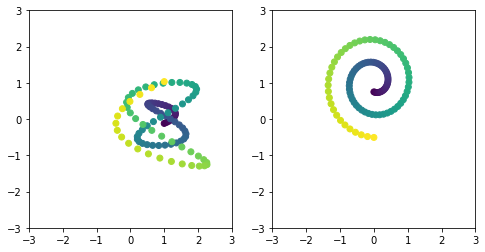

In [1]:
import numpy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import utils

X,Y   = utils.getdata()
p1,p2 = utils.plotdata(X,Y)

For these two trajetories, that can be understood as two different modalities of the same data, we would like determine under which projections they appear maximally correlated.

### Implementing Primal CCA

As stated in the lecture, the CCA problem in its primal form consists of maximizing the cross-correlation objective:

$$J(w_x,w_y) =  w_x^\top C_{xy} w_y$$

subject to autcorrelation constraints $w_x^\top C_{xx} w_x = 1$ and $w_y^\top C_{yy} w_y = 1$. Using the method of Lagrange multipliers, this optimization problem can be reduced to finding the first eigenvector of the generalized eigenvalue problem:

$$
\begin{bmatrix}0 & C_{xy}\\C_{yx} & 0\end{bmatrix}
\begin{bmatrix}w_x\\w_y\end{bmatrix} =
\lambda
\begin{bmatrix}C_{xx} & 0\\0 & C_{yy}\end{bmatrix}
\begin{bmatrix}w_x\\w_y\end{bmatrix} 
$$

Your first task is to write a function that solves the CCA problem in the primal (i.e. that solves the generalized eigenvalue problem above). The function you need to implement receives two matrices `X` and `Y` of size `N` $\times$ `d1` and  `N` $\times$ `d2` respectively. It returns two vectors of size `d1` and `d2` corresponding to the projections associated to the modalities `X` and `Y`. *(Hint: Note that the data matrices `X` and `Y` have not been centered yet.)*

In [2]:
X.shape, Y.shape

((100, 2), (100, 2))

In [3]:
import numpy as np
from scipy.linalg import eig

def CCAprimal(X,Y):
    N = X.shape[0]
    
    #center the data
    X = X - np.mean(X, axis=0)
    Y = Y - np.mean(Y, axis=0)
    
    #compute auto and cross covariances
    C_xx, C_yy = [(1/N)*data.T.dot(data) for data in [X,Y]]
    C_xy = (1/N)*X.T.dot(Y)
    C_yx = (1/N)*Y.T.dot(X)
    
    #size of wx and wy
    d1, d2 = C_xy.shape
    
    #assemble the formular
    cross_mat, auto_mat = [np.zeros((d1+d2,)*2) for _ in range(2)]
    cross_mat[:d1,d1:] = C_xy
    cross_mat[d1:,:d1] = C_yx
    auto_mat[:d1,:d1]  = C_xx
    auto_mat[d1:,d1:]  = C_yy
    
    #compute eigenvalues and eigenvectors
    eig_values, eig_vectors = eig(a=cross_mat,b=auto_mat)
    
    #eigenvectors are sorted in ascending order, therefore pick last one as solution
    wx_wy = eig_vectors[:,-1]
    wx,wy = wx_wy[:d1], wx_wy[d1:]
    
    return wx/np.linalg.norm(wx),wy/np.linalg.norm(wy)

The function can now be called with our dataset. The learned projection vectors $w_x$ and $w_y$ are plotted as red arrows.

[0.09026166 0.99591809] [ 0.92124018 -0.38899427]


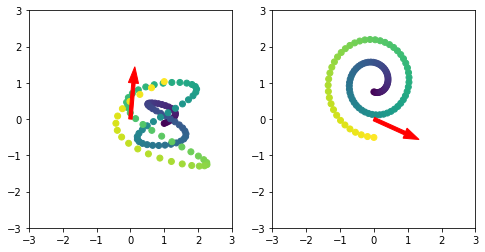

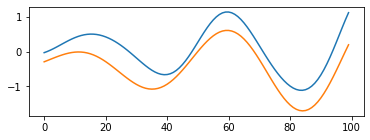

In [4]:
wx,wy = CCAprimal(X,Y)
print(wx,wy)

p1,p2 = utils.plotdata(X,Y)
p1.arrow(0,0,1*wx[0],1*wx[1],color='red',width=0.1)
p2.arrow(0,0,1*wy[0],1*wy[1],color='red',width=0.1)
plt.show()

plt.figure(figsize=(6,2))
plt.plot(numpy.dot(X,wx))
plt.plot(numpy.dot(Y,wy))
plt.show()

[0.09404939 0.99556753] [ 0.91704916 -0.39877416]


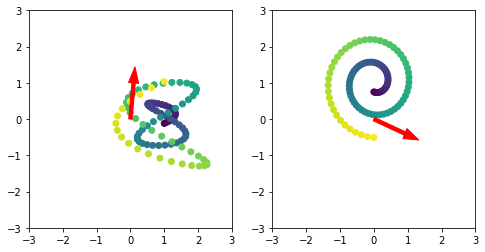

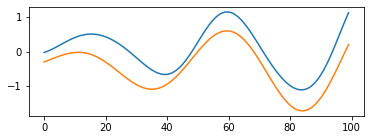

In [5]:
#checking my own solution above with scikit learn
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1).fit(X,Y)

wx,wy = np.squeeze(cca.x_weights_), np.squeeze(cca.y_weights_)
print(wx,wy)

p1,p2 = utils.plotdata(X,Y)
p1.arrow(0,0,1*wx[0],1*wx[1],color='red',width=0.1)
p2.arrow(0,0,1*wy[0],1*wy[1],color='red',width=0.1)
plt.show()

plt.figure(figsize=(6,2))
plt.plot(numpy.dot(X,wx))
plt.plot(numpy.dot(Y,wy))
plt.show()

Clearly, the data is correlated in the projected space.

### Implementing Dual CCA

In the second part of the exercise, we consider the case where the data is high dimensional (with `d` $\gg$ `N`). Such high-dimensionality occurs for example, when input data are images. We consider the scenario where sources emit spatially, and two (noisy) receivers measure the spatial field at different locations. We would like to identify signal that is common to the two measured locations, e.g. a given source emitting at a given frequency. We first load the data and show one example.

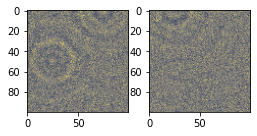

In [6]:
X,Y = utils.getHDdata()

utils.plotHDdata(X[0],Y[0])
plt.show()

Several sources can be perceived, however, there is a significant level of noise. Here again, we will use CCA to find subspaces where the two modalities are maximally correlated. In this example, because there are many more dimensions than there are data points, it is more advantageous to solve CCA in the dual. Your task is to implement a CCA dual solver that receives two data matrices of size `N` $\times$ `d1` and `N` $\times$ `d2` respectively as input, and returns the associate CCA directions (two vectors of respective sizes `d1` and `d2`).

In [7]:
def CCAdual(X,Y):
    N = X.shape[0]
    reg = 0.05
    
    X = X - np.mean(X, axis=0)
    Y = Y - np.mean(Y, axis=0)
    
    #compute kernels
    K_x = X.dot(X.T)
    K_y = Y.dot(Y.T)
    K_x_reg = K_x + reg*np.identity(N)
    K_y_reg = K_y + reg*np.identity(N)
    
    #compute block matrix components
    K_xx = K_x_reg.dot(K_x_reg)
    K_yy = K_y_reg.dot(K_y_reg)
    K_xy = K_x.dot(K_y)
    K_yx = K_y.dot(K_x)
    
    #get dims of X and Y
    d1, d2 = K_xy.shape
    
    #assemble block matrix to solve as eigenvalue problem
    cross_mat, auto_mat = [np.zeros((d1+d2,)*2) for _ in range(2)]
    cross_mat[:d1,d1:] = K_xy
    cross_mat[d1:,:d1] = K_yx
    auto_mat[:d1,:d1]  = K_xx
    auto_mat[d1:,d1:]  = K_yy
    
    #compute eigenvectors
    eigen_values, eig_vectors = eig(a=cross_mat,b=auto_mat)
    
    #pick eigenvector corresponding to largest eigenvalue
    idx = np.argmax(eigen_values)
    alpha = eig_vectors[:,idx]
    
    #get solutions in kernel space
    alpha_x,alpha_y = alpha[:d1], alpha[d1:]
    
    #compute solutions in input space
    wx, wy = X.T.dot(alpha_x), Y.T.dot(alpha_y)

    return wx, wy

We now call the function we have implemented with a training sequence of 100 pairs of images. Because the returned solution is of same dimensions as the inputs, it can be rendered in a similar fashion.

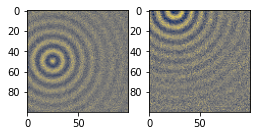

In [8]:
wx,wy = CCAdual(X[:100],Y[:100])

utils.plotHDdata(wx,wy)
plt.show()

Here, we can clearly see a common factor that has been extracted between the two fields, specifically a point source emitting at a particular frequency. A test sequence of 100 pairs of images can now be projected on these two filters:

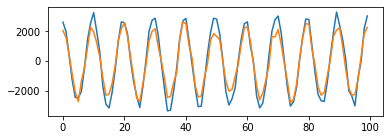

In [9]:
plt.figure(figsize=(6,2))
plt.plot(numpy.dot(X[100:],wx))
plt.plot(numpy.dot(Y[100:],wy))
plt.show()

Clearly the two projected signals are correlated and the input noise has been strongly reduced.